# Fitting multiple datasets using MultiFitter
Often we have multiple datasets for a Miyake event. Instead of fitting a model to each dataset indivudually, we can use a MultiFitter object to fit to all the datasets at once! Here's how we can do it,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
import jax.numpy as jnp
from jax import jit
from ticktack import fitting
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_82850/2273207293.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-colorblind')


In [2]:
ls ../../notebooks/775CE/

Büntgen18_CHN01.csv     Büntgen18_SWE05.csv     Jull14_Bristlecone.csv
Büntgen18_GER01.csv     Büntgen18_USA02.csv     Miyake12_Cedar.csv
Büntgen18_GER07.csv     Büntgen18_USA11.csv     Rakowski15_Oak.csv
Büntgen18_JAP01.csv     Büntgen18_USA18.csv     Scifo19_Oak.csv
Büntgen18_MON03.csv     Guttler15_Kauri.csv


First, we need to make a directory and place our datasets inside it. Each dataset should be a csv file, and has the same format as `example.csv`.


### Example 1: Fit a sinusoid model to the `775CE` Miyake event with `MCMC`.

In [3]:
mf, sampler = fitting.fit_event(year=775, # the year of the event
                                path='../../notebooks/775CE/', 
                                production_model="simple_sinusoid", 
                                sampler="MCMC", 
                                params=jnp.array([775.1, -1., 1.6, np.log10(6.5)]),  # start date, duration, phase, area
                                low_bounds=jnp.array([770., -1.5, 0, -2]),
                                up_bounds=jnp.array([780., 1.5, 11, 1.5]),
                                burnin=500, production=2000)

samples = sampler.copy()
samples[:,1] = 10**samples[:,1] # duration not log duration
samples[:,-1] = 10**samples[:,-1] # area not log area

Retrieving data...


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 22.33it/s]


Running burn-in...


100%|█████████████████████████████████████████| 500/500 [01:56<00:00,  4.31it/s]


Running production...


100%|███████████████████████████████████████| 2000/2000 [07:55<00:00,  4.20it/s]


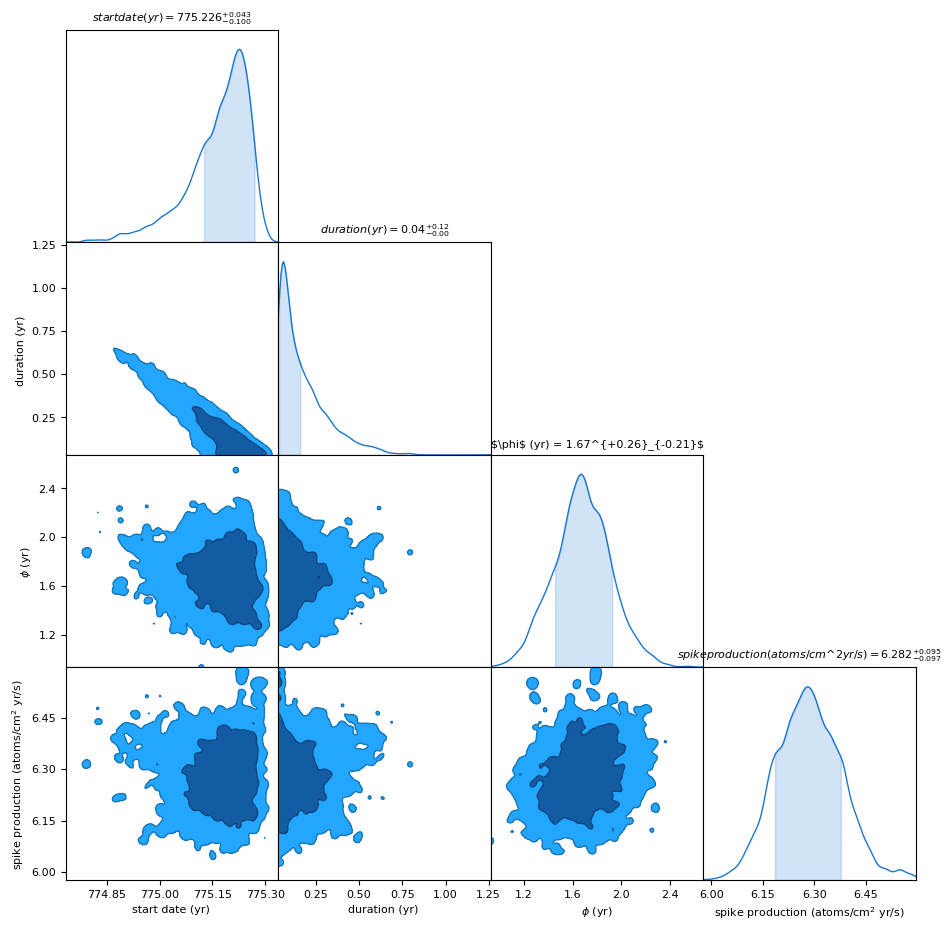

In [4]:
labels = ["start date (yr)", "duration (yr)", "$\phi$ (yr)", "spike production (atoms/cm$^2$ yr/s)"]
mf.chain_summary(samples, walkers=8, labels=labels); # by default walker = dim(params) * 2

This is a rough estimate of the posterior of these parameters. We can get a much better corner plot if the burn-in steps and the production steps are higher (say 1000).

We can also define a custom parametric production model for fitting a MultiFitter. Here we will use a simple flat production function with a super gaussian spike. The only parameters for this model are: start date of the event, duration of the event, spike production

### Example 2: Fit a custom model to the `775CE` Miyake event with `MCMC`.

In [5]:
@jit
def super_gaussian(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)

@jit
def super_gaussian_pulse(t, *args):
    start_time, duration, area = jnp.array(list(args)).reshape(-1)
    height = super_gaussian(t, start_time, duration, area)
    production = 1.76 + height # 1.76 is the default steady state production rate
    return production

In [6]:
mf, sampler = fitting.fit_event(year=775, 
                                path='../../notebooks/775CE/', 
                                production_model=super_gaussian_pulse, 
                                sampler="MCMC", 
                                params=jnp.array([775.1, 0.3, 6.5]), 
                                low_bounds=jnp.array([770., 0., 0.]),
                                up_bounds=jnp.array([780., 5., 15.]), 
                                burnin=500, production=2000)

samples = sampler.copy()
samples[:,1] = 10**samples[:,1] # duration not log duration
samples[:,-1] = 10**samples[:,-1] # area not log area

Retrieving data...


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 181.15it/s]

Running burn-in...



100%|█████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s]


Running production...


100%|███████████████████████████████████████| 2000/2000 [05:35<00:00,  5.97it/s]


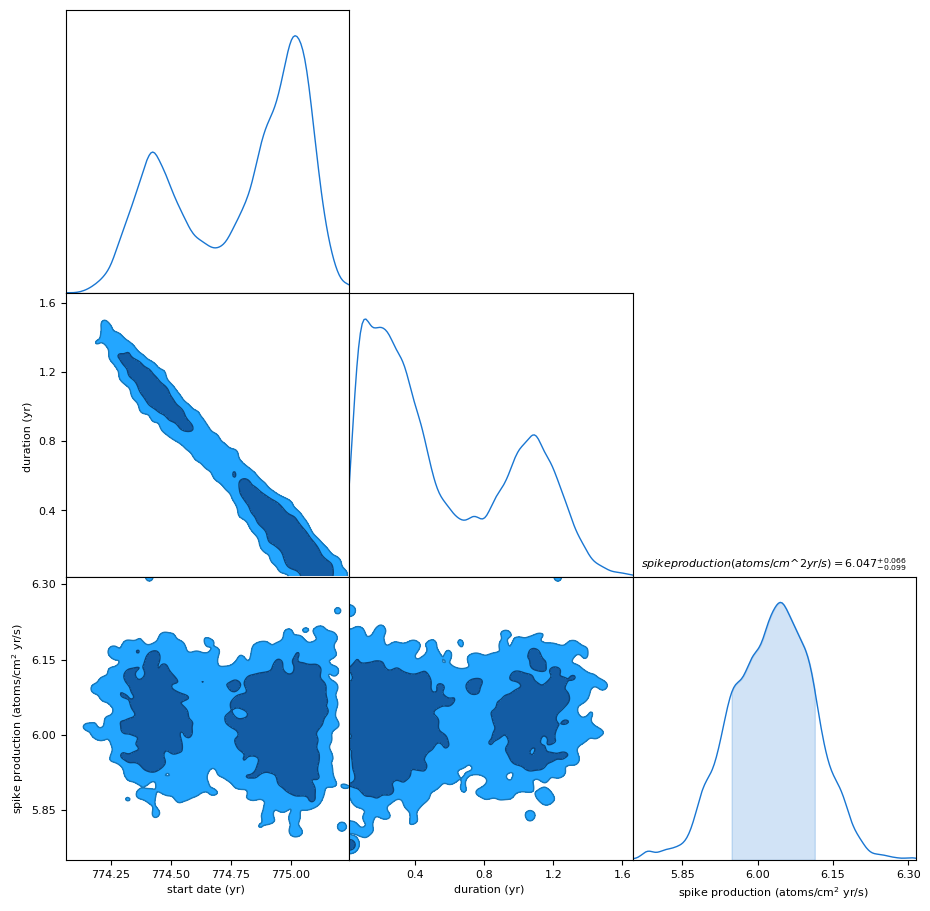

In [7]:
labels = ["start date (yr)", "duration (yr)", "spike production (atoms/cm$^2$ yr/s)"]
mf.chain_summary(sampler, walkers=6, labels=labels);